<a href="https://colab.research.google.com/github/purvasingh96/Deep-Reinforcement-Learning/blob/master/4.%20Deep%20Q%20Networks/Credit_Card_Fraud_Detection_via_DQNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import shutil

shutil.rmtree('/content/gym-fraud-detection')

In [0]:
import os
print(os.getcwd())
!unzip dataset.zip

In [0]:
!unzip gym-fraud-detection.zip

In [0]:
import os
os.chdir('gym-fraud-detection')

In [0]:
pip install -e .

In [0]:
import gym
import gym_fraud_detection

In [0]:

os.chdir('/content')
env = gym.make('gym-fraud-detection-v0')

In [0]:

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [0]:

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:

actions = []
rewards = []
count = 5

while True:
  action = env.action_space.sample()
  reward = env.step(action)
  actions.append(action)
  rewards.append(reward)
  count -= 1
  if count==0:
    break

State idx : 1
Value of next_state : [ 0.          1.19185711  0.26615071  0.16648011  0.44815408  0.06001765
 -0.08236081 -0.07880298  0.08510165 -0.25542513 -0.16697441  1.61272666
  1.06523531  0.48909502 -0.1437723   0.63555809  0.46391704 -0.11480466
 -0.18336127 -0.14578304 -0.06908314 -0.22577525 -0.63867195  0.10128802
 -0.33984648  0.1671704   0.12589453 -0.0089831   0.01472417  2.69      ]
State idx : 2
Value of next_state : [ 1.00000000e+00 -1.35835406e+00 -1.34016307e+00  1.77320934e+00
  3.79779593e-01 -5.03198133e-01  1.80049938e+00  7.91460956e-01
  2.47675787e-01 -1.51465432e+00  2.07642865e-01  6.24501459e-01
  6.60836853e-02  7.17292731e-01 -1.65945923e-01  2.34586495e+00
 -2.89008319e+00  1.10996938e+00 -1.21359313e-01 -2.26185710e+00
  5.24979725e-01  2.47998153e-01  7.71679402e-01  9.09412262e-01
 -6.89280956e-01 -3.27641834e-01 -1.39096572e-01 -5.53527940e-02
 -5.97518406e-02  3.78660000e+02]
State idx : 3
Value of next_state : [ 1.00000000e+00 -9.66271712e-01 -1.8

In [0]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils

In [0]:

df = pd.read_csv('./dataset/creditcard.csv')
df.head(1) # give us a sneek preview of the dataset xD

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.5516,-0.617801,-0.99139,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [0]:

X = df.iloc[:, :-1].values 
y = df.iloc[:, -1].values

sc = StandardScaler()
X = sc.fit_transform(X)

In [0]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 16)
        self.fc2 = nn.Linear(16, 18)
        self.fc3 = nn.Linear(18, 20)
        self.fc4 = nn.Linear(20, 24)
        self.fc5 = nn.Linear(24, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.25)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [0]:
import random 
from collections import namedtuple, deque 

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network
EPSILON = 0.8           # probability of chosing on-policy action

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class Agent():
  def __init__(self, action_size, seed):
    self.action_size = action_size
    self.seed = random.seed(seed)


    # Q - Network
    self.qnet_local = DQN().double().to(device)
    self.qnet_target = DQN().double().to(device)

    self.optimizer = optim.Adam(self.qnet_local.parameters(), lr=0.001)

    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

    self.t_step = 0
    self.train_loss = []

  def step(self, state, action, reward, next_state, done):
    self.memory.add(state, action, reward, next_state, done)


    # learn every 4 timesteps
    self.t_step = (self.t_step+1)%64
    if self.t_step == 0:
      experience = self.memory.sample()
      #print('Experience sampled from memory : ', experience)
      self.learn(experience, GAMMA)


  def epsilon_greedy_action(self, state):
    state = state.to(device)
    self.qnet_local.eval()
    with torch.no_grad():
      action_values = self.qnet_local(state).max(1)[1]#.view(1, 1)
    self.qnet_local.train()

    if random.random() < 0.8:
      print('Predicted action based on QNetwork : ', action_values)
      return action_values.cpu()
    else:
      random_action = random.choices(np.arange(self.action_size), k=BATCH_SIZE)
      print('Chosing  random actions for the batch : ', random_action)
      return torch.DoubleTensor(random_action)
  
  def learn(self, experiences, gamma):
    #print('Started learning')
    states, actions, rewards, next_states, done = experiences#experiences[0].state, experiences[0].action, experiences[0].reward, experiences[0].next_state, experiences[0].done 
    criterion = torch.nn.BCELoss()
    self.qnet_local.train()
    self.qnet_target.eval()

    #predicted_targets = self.qnet_local(states)#.gather(1, actions)

    #print(next_states.view(1, 1))
    with torch.no_grad():
      labels_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
    
    #print('labels_next {}'.format(labels_next))
    
    labels = 0 + (gamma * labels_next)
    predicted_targets = self.qnet_local(states).gather(1, actions.long())

    #print("Predicted targets : {}, labels : {}".format(predicted_targets, labels))

    loss = criterion(predicted_targets, labels).to(device)
    print("===========================Training loss ============================")
    print(loss.item())
    self.train_loss.append(loss.item())
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    print('Total training losses : ', self.train_loss)

    # perform soft update
    self.soft_update(self.qnet_local, self.qnet_target, TAU)
  
  def soft_update(self, local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)

In [0]:
class ReplayBuffer():
  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size
    self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)
  
  def add(self, state, action, reward, next_state, done):
    experience = self.experiences(state, action, reward, next_state, done)
    self.memory.append(experience)

  def sample(self):
     experiences = random.sample(self.memory, k=self.batch_size)
     #print('Experiences : ', experiences)
     states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).double().to(device)
     actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).double().to(device)
     rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).double().to(device)
     next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).double().to(device)
     dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).double().to(device)
     return (states, actions, rewards, next_states, dones)

    # experiences = random.sample(self.memory, k=BATCH_SIZE)

    # batch = self.experiences(*zip(experiences))

    # states = torch.cat(batch.state)
    # actions = torch.cat(batch.actions)
    # rewards = torch.cat(batch.reward)
    # next_states = torch.cat(batch.next_state)
    # dones = torch.cat(batch.done)
    #return random.sample(self.memory, BATCH_SIZE)

    
  
  def __len__(self):
      return len(self.memory)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train).double()

train = data_utils.TensorDataset(X_train, Y_train)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
# check reward strategy once
# add probability to epsilon_greedy
import json
deep_agent = Agent(action_size=2, seed=0)
num_episodes = 1
max_t = 1000
state = 0
env.state_idx = 0

true_positive = []
true_negative = []

false_positive = []
false_negative = []

TPR = []
FPR = []

current_state = df.iloc[0, :-1].values

for i in range(1):  
  #print("==========================EPOCH {} COMPLETED===================".format(i))  

  print('Current state : ', i)
  score = 0
  for state_idx, data in enumerate(train_loader, 0):
    inputs, labels = data    
    action = deep_agent.epsilon_greedy_action(inputs)
    for a in action:
      #print('action taken : ', action)
      next_state, reward, done, info = env.step(a)
      #print('Next state dtype ; ', next_state.dtype)
      #print('Next state ', next_state)
      deep_agent.step(current_state, a, reward, next_state, done)
      current_state = next_state
      #state = next_state
      #score += reward
      roc_info = json.loads(info)
      
      
     

Text(0, 0.5, 'training loss')

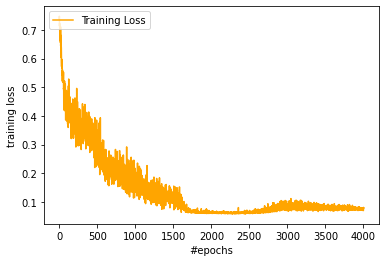

In [192]:
import numpy as np
import matplotlib.pyplot as plt

#plt.plot(x, y1, "-b", label="sine")


plt.plot(range(4005), deep_agent.train_loss, color='orange', label='Training Loss')
plt.legend(loc="upper left")
plt.xlabel('#epochs')
plt.ylabel('training loss')

In [0]:
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test).double()

In [0]:
test = data_utils.TensorDataset(X_test, Y_test)
test_loader = data_utils.DataLoader(test, batch_size=64, shuffle=True)


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        predicted = deep_agent.epsilon_greedy_action(inputs)        
        total += labels.size(0)
        print(predicted.dtype)
        correct += (predicted.double()==labels).sum().item() 
        print(100*correct/total)
        

print('Accuracy of the network on the {} inputs: {}'.format(
    X_test.shape[0], 100 * correct/total))

Chosing  random actions for the batch :  [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]
torch.float64
46.875
Predicted action based on QNetwork :  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
torch.int64
71.875
Chosing  random actions for the batch :  [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
torch.float64
65.10416666666667
Predicted action based on QNetwork :  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,